# TP 4 Regression logistique avec régularisation
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un profuit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(118, 3)

Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2];
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (118, 3)  y  (118, 1)


In [5]:
X[:10]

array([[ 1.      ,  0.051267,  0.69956 ],
       [ 1.      , -0.092742,  0.68494 ],
       [ 1.      , -0.21371 ,  0.69225 ],
       [ 1.      , -0.375   ,  0.50219 ],
       [ 1.      , -0.51325 ,  0.46564 ],
       [ 1.      , -0.52477 ,  0.2098  ],
       [ 1.      , -0.39804 ,  0.034357],
       [ 1.      , -0.30588 , -0.19225 ],
       [ 1.      ,  0.016705, -0.40424 ],
       [ 1.      ,  0.13191 , -0.51389 ]])

In [6]:
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités

**Réponse**: 
methode 1 : dans notre cas X est un trinôme, il a 2 variables alors pour connaitre nombre de termes avec n degres on applique cette regle :
(n+1)*(n+2)/(2)=
7*8/2=56/2=28 

En général ça sera : (n+m-1)!/((n!)*((m-1)!)).
où m est le nombre de variables
---

methode 2 : La formule dgénérale pour obtenir le nombre des caractéristiques d'un polymone à 2 variables va etre :

la somme (i) pour i de 1 à (n+1) , tel que n est le degrée de la fonction polynomiale.


In [7]:
def numberfeatures(degree):
    f=0
    for i in range(1,degree+2):
        f=f+i
    return f

In [8]:
numberfeatures(6)

28

In [9]:
def mapping(X):
    
    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j));
            k=k+1
    return outX    


In [10]:
XM=mapping(X)
XM.shape

(118, 28)

In [11]:
XM[0]

array([1.00000000e+00, 5.12670000e-02, 6.99560000e-01, 2.62830529e-03,
       3.58643425e-02, 4.89384194e-01, 1.34745327e-04, 1.83865725e-03,
       2.50892595e-02, 3.42353606e-01, 6.90798869e-06, 9.42624411e-05,
       1.28625106e-03, 1.75514423e-02, 2.39496889e-01, 3.54151856e-07,
       4.83255257e-06, 6.59422333e-05, 8.99809795e-04, 1.22782870e-02,
       1.67542444e-01, 1.81563032e-08, 2.47750473e-07, 3.38066048e-06,
       4.61305487e-05, 6.29470940e-04, 8.58939846e-03, 1.17205992e-01])

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [12]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));
 

In [13]:
k=Sigmoid(-10)
k

4.5397868702434395e-05

In [14]:
def logistic(h):
    for i in range(h.shape[0]):
        h[i] = Sigmoid(h[i])
    return h

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [15]:
def computeCost(X, y, theta):
    h = np.matmul(X, theta)
    H = logistic(h)
    m = X.shape[0]
#     print((y*np.log(H+0.00001) + (1-y)*np.log(1-H+0.00001)))
    return sum((y*np.log(H+0.00001) + (1-y)*np.log(1-H+0.00001))) / (-m)

In [16]:
# L2 regularization (Ridge)
# landa is the regularization parameter
# keeping landa small to avoid overfitting
# landa = 0 ==> no regulariztion effect
def computeCostReg(X, y, theta, landa):
    m = X.shape[0]
    a = sum(computeCost(X, y, theta)) / m
    b = sum(np.square(theta)) * (landa / (2 * m))
    return a + b

2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [17]:
def gradientDescent(X, y, theta, alpha, iterations, lada):
    m = X.shape[0]
    
    for i in range(iterations):
        H = logistic(np.matmul(X,theta))
        
        diff = np.subtract(H, y)
        
        t = theta
        t[0]= 0
        a = np.matmul(np.transpose(X), diff)
        theta = theta - alpha*(a + lada * t)/m
        
       
    return theta

In [18]:
# c'est le meme GD avec le précédent, just cette GD calcul le cout et  le cout regularized pour le traçage de fonction de cout
def gradientDescent2(X, y, theta, alpha, iterations, lada):
    m = X.shape[0]

    theta_costs = []
    cost = computeCost(X, y, theta)
    t = np.asarray(theta.flatten())
    t=np.append(t,cost)
    theta_costs.append(t)

    theta_costs_reg = []
    cost = computeCostReg(X, y, theta, lada)
    t = np.asarray(theta.flatten())
    t=np.append(t,cost)
    theta_costs_reg.append(t)

    for i in range(iterations):
        H = logistic(np.matmul(X,theta))
        
        diff = np.subtract(H, y)
        
        t = theta
        t[0]= 0
        a = np.matmul(np.transpose(X), diff)
        theta = theta - alpha*(a + lada * t)/m
        
        cost = computeCost(X, y, theta)
        t = np.asarray(theta.flatten())
        t=np.append(t,cost)
        theta_costs.append(t)
        cost = computeCostReg(X, y, theta, lada)
        t = np.asarray(theta.flatten())
        t=np.append(t,cost)
        theta_costs_reg.append(t)
       
    return theta,theta_costs,theta_costs_reg

# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [19]:
n=XM.shape[1]
theta = np.ones((n, 1))


Calculer le cout initial

In [20]:
initialCost=computeCost(XM, y, theta)
print(initialCost)

[2.00337545]


In [21]:
computeCostReg(XM, y, theta, 1)

array([0.13562183])

Appel des la fonction de calcul du gradient

In [22]:
# paramètres
iterations = 2000;
alpha = 0.1;

# paramètre de regression
lambdaa = 1;
#lambdaa = 10;
n=XM.shape[1]
theta = np.ones((n, 1))
theta =gradientDescent(XM, y, theta, alpha, iterations, lambdaa);
theta

array([[ 1.00561713e-02],
       [ 3.47038054e-01],
       [ 1.01947435e+00],
       [-7.07581005e-01],
       [-9.65182383e-01],
       [ 6.75352280e-02],
       [ 1.34463223e-01],
       [-3.33065313e-01],
       [-2.02417745e-01],
       [-1.66677158e-01],
       [-1.05390377e+00],
       [-1.30442188e-02],
       [-3.65932272e-01],
       [-1.83614021e-01],
       [-8.46827397e-01],
       [-1.99504391e-01],
       [-1.14269803e-01],
       [ 8.17235223e-02],
       [-1.60488843e-01],
       [-1.18085446e-01],
       [-5.75850932e-01],
       [-8.66594517e-01],
       [ 1.21566086e-01],
       [-1.20099174e-01],
       [ 1.40655606e-01],
       [-1.68795687e-01],
       [ 5.26985269e-06],
       [-9.51086839e-01]])

In [24]:
np.shape(theta)

(28, 1)

In [30]:
np.shape(np.ravel(theta))

(28,)

In [29]:
theta

array([[ 1.00561713e-02],
       [ 3.47038054e-01],
       [ 1.01947435e+00],
       [-7.07581005e-01],
       [-9.65182383e-01],
       [ 6.75352280e-02],
       [ 1.34463223e-01],
       [-3.33065313e-01],
       [-2.02417745e-01],
       [-1.66677158e-01],
       [-1.05390377e+00],
       [-1.30442188e-02],
       [-3.65932272e-01],
       [-1.83614021e-01],
       [-8.46827397e-01],
       [-1.99504391e-01],
       [-1.14269803e-01],
       [ 8.17235223e-02],
       [-1.60488843e-01],
       [-1.18085446e-01],
       [-5.75850932e-01],
       [-8.66594517e-01],
       [ 1.21566086e-01],
       [-1.20099174e-01],
       [ 1.40655606e-01],
       [-1.68795687e-01],
       [ 5.26985269e-06],
       [-9.51086839e-01]])

In [22]:

# Appel
theta,theta_costs,theta_costs_reg = gradientDescent2(XM, y, theta, alpha, iterations, lambdaa);

In [23]:
theta

array([[ 1.00561713e-02],
       [ 3.47038054e-01],
       [ 1.01947435e+00],
       [-7.07581005e-01],
       [-9.65182383e-01],
       [ 6.75352280e-02],
       [ 1.34463223e-01],
       [-3.33065313e-01],
       [-2.02417745e-01],
       [-1.66677158e-01],
       [-1.05390377e+00],
       [-1.30442188e-02],
       [-3.65932272e-01],
       [-1.83614021e-01],
       [-8.46827397e-01],
       [-1.99504391e-01],
       [-1.14269803e-01],
       [ 8.17235223e-02],
       [-1.60488843e-01],
       [-1.18085446e-01],
       [-5.75850932e-01],
       [-8.66594517e-01],
       [ 1.21566086e-01],
       [-1.20099174e-01],
       [ 1.40655606e-01],
       [-1.68795687e-01],
       [ 5.26985269e-06],
       [-9.51086839e-01]])

In [24]:
computeCost(XM,y,theta)

array([0.56214895])

In [25]:
np.shape(np.asmatrix(theta_costs))

(2001, 29)

Traçage de la fonction du coût

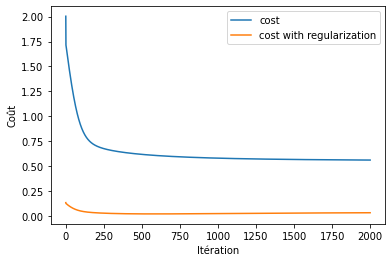

cost debut [[2.00337545]]
cost fin [[0.56214895]]
cost avec regularization debut [[0.13562183]]
cost avec regularization fin [[0.0342298]]


In [26]:
x = [i for i in range(iterations+1)]

theta_costs = np.asmatrix(theta_costs)
costs = theta_costs[:,n]
theta_costs_reg = np.asmatrix(theta_costs_reg)
costs_reg = theta_costs_reg[:,n]

plt.plot(x, costs, label='cost')
plt.plot(x, costs_reg, label='cost with regularization')
plt.xlabel('Itération')
plt.ylabel('Coût')
plt.legend(loc='best')
plt.show()
print('cost debut {}'.format(costs[0]))
print('cost fin {}'.format(costs[-1]))
print('cost avec regularization debut {}'.format(costs_reg[0]))
print('cost avec regularization fin {}'.format(costs_reg[-1]))

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [27]:
def predict(X,theta):
    return np.matmul(X,theta)


In [28]:
def classer(Y,seuil):
    C = np.zeros((Y.shape[0],1))
    for i in range(Y.shape[0]):
        if(Y[i]>seuil):
            C[i] = 1
      
    
    return C


# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [29]:
def prepareData(X):
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1


    xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))


    X2 = np.c_[xx_train.ravel(), yy_train.ravel()] # np.concatenate(axis=1)
    intercept = np.ones((X2.shape[0],1))
    X2 = np.column_stack((intercept,X2))
    XM2 = mapping(X2)
    return XM2,xx_train,yy_train

**decision boundary avec regularization**

Text(0.5, 1.0, 'decision boundary avec regularization')

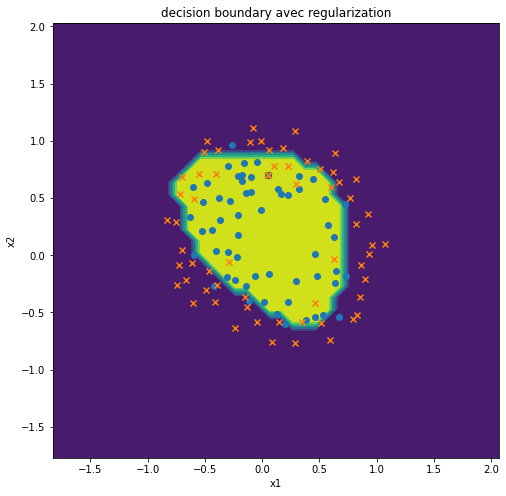

In [30]:
XM2,x1,x2 = prepareData(X)
seuil = -0.45
y_pred= predict(XM2,theta)
y_classe = classer(y_pred,seuil)
y_classe = y_classe.reshape(x1.shape)
plt.figure(figsize=(8,8))
plt.contourf(x1, x2, y_classe)
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="accepte",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="non accepte",marker ='x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("decision boundary avec regularization")

**On remarque que ce model avec regularization généralise bien sans tomber dans le sur-apprentissage**

# Equation Normale

In [31]:
def normalEquation(X,Y,landa,E):
    return np.linalg.inv(X.T.dot(X) + landa*E).dot(X.T).dot(Y)


In [32]:
E = np.identity(n)

In [33]:
E[0][0] = 0

In [34]:
E = E.reshape(n,n)

In [35]:
t = normalEquation(XM,y,1,E)

In [36]:
t.reshape(1,t.shape[0])

array([[ 0.94416708,  0.2315894 ,  0.41142826, -0.7380916 , -0.50116657,
        -0.69193639,  0.1003575 , -0.10718673, -0.06667559, -0.05556887,
        -0.45471969,  0.09321721, -0.23956536, -0.07088082, -0.40279421,
         0.04618662, -0.01432296,  0.04153635, -0.10356044, -0.02654812,
         0.05619122, -0.18296629,  0.12363998, -0.11445861,  0.06788982,
        -0.10602358,  0.04149463, -0.05781815]])

In [37]:
theta.reshape(1,theta.shape[0])

array([[ 1.00561713e-02,  3.47038054e-01,  1.01947435e+00,
        -7.07581005e-01, -9.65182383e-01,  6.75352280e-02,
         1.34463223e-01, -3.33065313e-01, -2.02417745e-01,
        -1.66677158e-01, -1.05390377e+00, -1.30442188e-02,
        -3.65932272e-01, -1.83614021e-01, -8.46827397e-01,
        -1.99504391e-01, -1.14269803e-01,  8.17235223e-02,
        -1.60488843e-01, -1.18085446e-01, -5.75850932e-01,
        -8.66594517e-01,  1.21566086e-01, -1.20099174e-01,
         1.40655606e-01, -1.68795687e-01,  5.26985269e-06,
        -9.51086839e-01]])

**cost de GD et normal equation sont presque similaires**
**mais equation normale est plus precise et généralise mieux que le GD et sans tomber dans le sur-apprentissage**

In [38]:
computeCost(XM,y,theta)

array([0.56214895])

In [39]:
computeCost(XM,y,t)

array([0.63205508])

**decision boundary avec regularization avec equation normale**

Text(0.5, 1.0, 'decision boundary avec regularization avec equation normale')

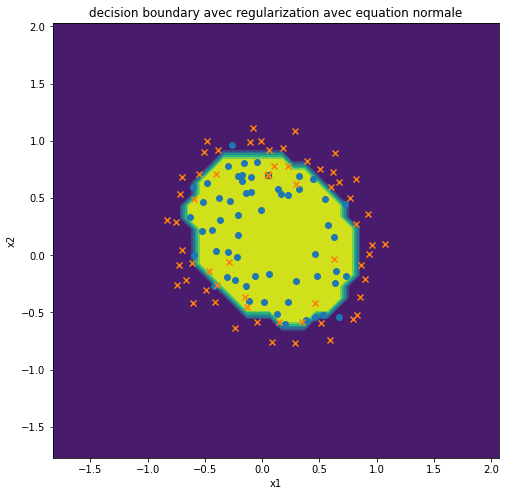

In [40]:
XM2,x1,x2 = prepareData(X)
seuil = 0.5
y_pred= predict(XM2,t)
y_classe = classer(y_pred,seuil)
y_classe = y_classe.reshape(x1.shape)
plt.figure(figsize=(8,8))
plt.contourf(x1, x2, y_classe)
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="accepte",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="non accepte",marker ='x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("decision boundary avec regularization avec equation normale")

**On remarque que ce model avec regularization généralise bien sans tomber dans le sur-apprentissage**

**decision boundary sans regularization avec equation normale**

In [41]:
t = normalEquation(XM,y,0,E)

Text(0.5, 1.0, 'decision boundary sans regularization avec equation normale')

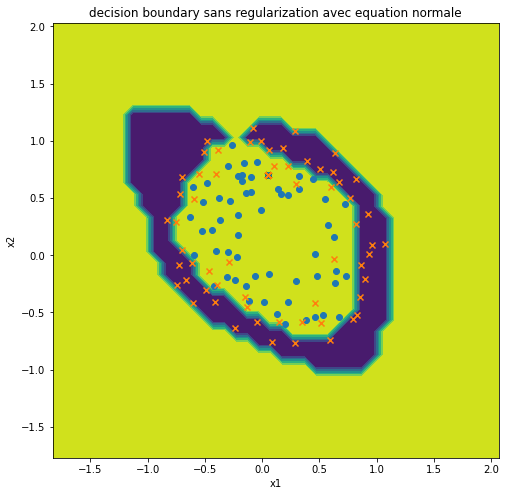

In [42]:
XM2,x1,x2 = prepareData(X)
seuil = 0.23
y_pred= predict(XM2,t)
y_classe = classer(y_pred,seuil)
y_classe = y_classe.reshape(x1.shape)
plt.figure(figsize=(8,8))
plt.contourf(x1, x2, y_classe)
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="accepte",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="non accepte",marker ='x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("decision boundary sans regularization avec equation normale")

**On remarque que ce model a sur-apprenti sans regularization**

**decision boundary avec regularization avec equation normale avec un grand valeur de lambda**

In [43]:
t = normalEquation(XM,y,100,E)

Text(0.5, 1.0, 'decision boundary avec beaucoup de regularization avec equation normale')

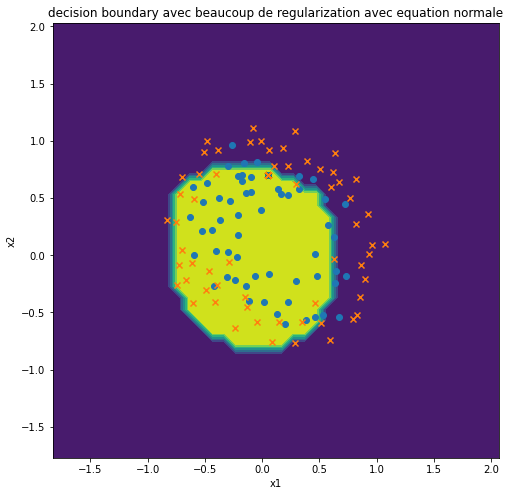

In [44]:
XM2,x1,x2 = prepareData(X)
seuil = 0.5
y_pred= predict(XM2,t)
y_classe = classer(y_pred,seuil)
y_classe = y_classe.reshape(x1.shape)
plt.figure(figsize=(8,8))
plt.contourf(x1, x2, y_classe)
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="accepte",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="non accepte",marker ='x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("decision boundary avec beaucoup de regularization avec equation normale")

**On remarque que ce model a sous-apprenti avec un grand valeur de lambda quelque soit la valeur de seuil**

# Qualité du classifieur

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [45]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_proba=predict(XM,theta)
y_predict = classer(y_proba, -0.45)
precision = np.mean(y==y_predict)*100

In [46]:
print("precision = {:.2f}%".format(precision))

precision = 81.36%


In [47]:
y_predict

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],

In [48]:
i=0
for d in data[:,:2]:
    print(f"note1= {d[0]} note2= {d[1]} r={y_predict[i]} ")
    i+=1

note1= 0.051267 note2= 0.69956 r=[1.] 
note1= -0.092742 note2= 0.68494 r=[1.] 
note1= -0.21371 note2= 0.69225 r=[1.] 
note1= -0.375 note2= 0.50219 r=[1.] 
note1= -0.51325 note2= 0.46564 r=[1.] 
note1= -0.52477 note2= 0.2098 r=[1.] 
note1= -0.39804 note2= 0.034357 r=[1.] 
note1= -0.30588 note2= -0.19225 r=[1.] 
note1= 0.016705 note2= -0.40424 r=[1.] 
note1= 0.13191 note2= -0.51389 r=[1.] 
note1= 0.38537 note2= -0.56506 r=[1.] 
note1= 0.52938 note2= -0.5212 r=[1.] 
note1= 0.63882 note2= -0.24342 r=[1.] 
note1= 0.73675 note2= -0.18494 r=[0.] 
note1= 0.54666 note2= 0.48757 r=[1.] 
note1= 0.322 note2= 0.5826 r=[1.] 
note1= 0.16647 note2= 0.53874 r=[1.] 
note1= -0.046659 note2= 0.81652 r=[1.] 
note1= -0.17339 note2= 0.69956 r=[1.] 
note1= -0.47869 note2= 0.63377 r=[1.] 
note1= -0.60541 note2= 0.59722 r=[1.] 
note1= -0.62846 note2= 0.33406 r=[1.] 
note1= -0.59389 note2= 0.005117 r=[0.] 
note1= -0.42108 note2= -0.27266 r=[0.] 
note1= -0.11578 note2= -0.39693 r=[0.] 
note1= 0.20104 note2= -0.60

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [49]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean
#from sklearn.preprocessing import StandardScaler

new_X = data[:,0:2]
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.25)

ridgeModel = Ridge(alpha = 1)
ridgeModel.fit(X_train, y_train)
scores = cross_val_score(ridgeModel, new_X, y, cv = 10)#cross-validation
precision = abs(mean(scores))*100
print(precision)

10.04335854445352


# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

In [50]:
def classifier(x):
    x=float(x)
    if(x>0.45):
        x=1
    else:
        x=0
    return x

In [51]:
# belongs to the class one in the original data
print(classifier(ridgeModel.predict([[-0.47869 ,   0.63377]])))
print(classifier(ridgeModel.predict([[-0.21947 , -0.016813]])))
print(classifier(ridgeModel.predict([[-0.13882  , -0.27266]])))
# belongs to the class zero in the original data
print(classifier(ridgeModel.predict([[-0.0063364, 0.99927]])))
print(classifier(ridgeModel.predict([[0.28744 , -0.76974]])))
print(classifier(ridgeModel.predict([[0.22408 ,  0.77997]])))


1
1
1
1
0
1


In [52]:
for d in data[:,:2]:
    print(f"note1= {d[0]} note2= {d[1]} r= {classifier(ridgeModel.predict([[d[0],d[1]]]))}")

note1= 0.051267 note2= 0.69956 r= 1
note1= -0.092742 note2= 0.68494 r= 1
note1= -0.21371 note2= 0.69225 r= 1
note1= -0.375 note2= 0.50219 r= 1
note1= -0.51325 note2= 0.46564 r= 1
note1= -0.52477 note2= 0.2098 r= 1
note1= -0.39804 note2= 0.034357 r= 1
note1= -0.30588 note2= -0.19225 r= 1
note1= 0.016705 note2= -0.40424 r= 0
note1= 0.13191 note2= -0.51389 r= 0
note1= 0.38537 note2= -0.56506 r= 0
note1= 0.52938 note2= -0.5212 r= 0
note1= 0.63882 note2= -0.24342 r= 0
note1= 0.73675 note2= -0.18494 r= 0
note1= 0.54666 note2= 0.48757 r= 1
note1= 0.322 note2= 0.5826 r= 1
note1= 0.16647 note2= 0.53874 r= 1
note1= -0.046659 note2= 0.81652 r= 1
note1= -0.17339 note2= 0.69956 r= 1
note1= -0.47869 note2= 0.63377 r= 1
note1= -0.60541 note2= 0.59722 r= 1
note1= -0.62846 note2= 0.33406 r= 1
note1= -0.59389 note2= 0.005117 r= 1
note1= -0.42108 note2= -0.27266 r= 1
note1= -0.11578 note2= -0.39693 r= 0
note1= 0.20104 note2= -0.60161 r= 0
note1= 0.46601 note2= -0.53582 r= 0
note1= 0.67339 note2= -0.53582

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 08 Avril 2022 à 22h


In [53]:
# bonne chance